Background:

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.


In [19]:
import pandas as pd
import numpy as np

from pathlib import Path

from collections import Counter

from scipy.stats import chi2_contingency

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from src.visualization.visualize import numerical_and_categorical,freqs_and_countplot
from src.features.build_features import preparing_data
from src.models.train_model import Model_creation

### Import & Read data

In [ ]:
project_dir = Path('__file__').resolve().parents[1]
file_path = project_dir.joinpath("data/raw/term-deposit-marketing-2020.csv")
file_path

In [ ]:
data=pd.read_csv(file_path)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [ ]:
# checking for duplicated values

data.duplicated().sum()

0

Neither null values not duplicated values are present in the dataset.

Both Categorical and numerical features are present, which needs to be treated.

In [ ]:
# descriptive statistics for numerical features

data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [ ]:
# descriptive statistics for categorical features

data.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,y
count,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,12,3,4,2,2,2,3,11,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,no
freq,9383,24386,20993,39191,24031,33070,24914,13532,37104


It seems like some outliers are present in duration, balance, campaign which we can explore later.

out of total rows(i.e, 40000) the count of class 'no' is 37104, this implies dataset is imbalanced.

In [ ]:
categorical_features=[]
numerical_features=[]
for i in data.columns:
    if data[i].dtypes=='int64':
        numerical_features.append(i)
    else:
        categorical_features.append(i)
print(f'categorical features : {categorical_features}')
print(f'numerical features : {numerical_features}')

categorical features : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
numerical features : ['age', 'balance', 'day', 'duration', 'campaign']


In [ ]:
for i in data:
    if i not in numerical_features:
        print(f'{i} : {data[i].unique()}')

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital : ['married' 'single' 'divorced']
education : ['tertiary' 'secondary' 'unknown' 'primary']
default : ['no' 'yes']
housing : ['yes' 'no']
loan : ['no' 'yes']
contact : ['unknown' 'cellular' 'telephone']
month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
y : ['no' 'yes']


<Axes: >

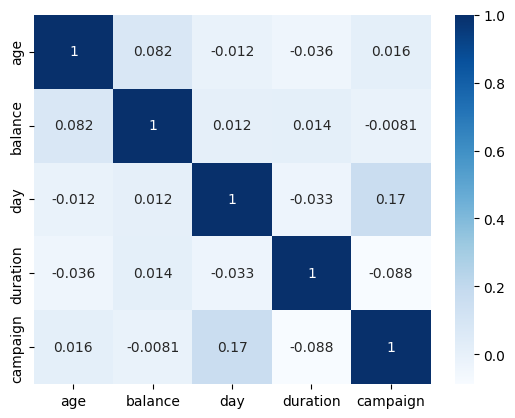

In [ ]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Blues')

### Exploratory Data Analysis

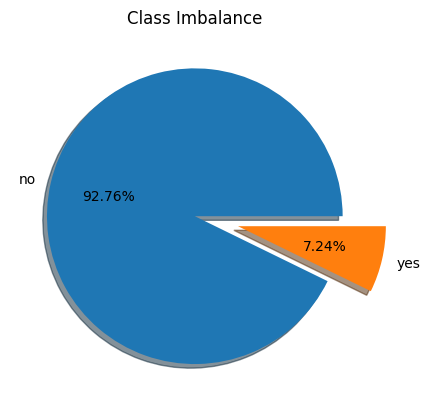

In [ ]:
# checking class imbalance
plt.pie(data['y'].value_counts(),labels=data['y'].value_counts().index,explode=[0,0.3],shadow=True,autopct='%2.2f%%')
plt.title('Class Imbalance')
plt.show()

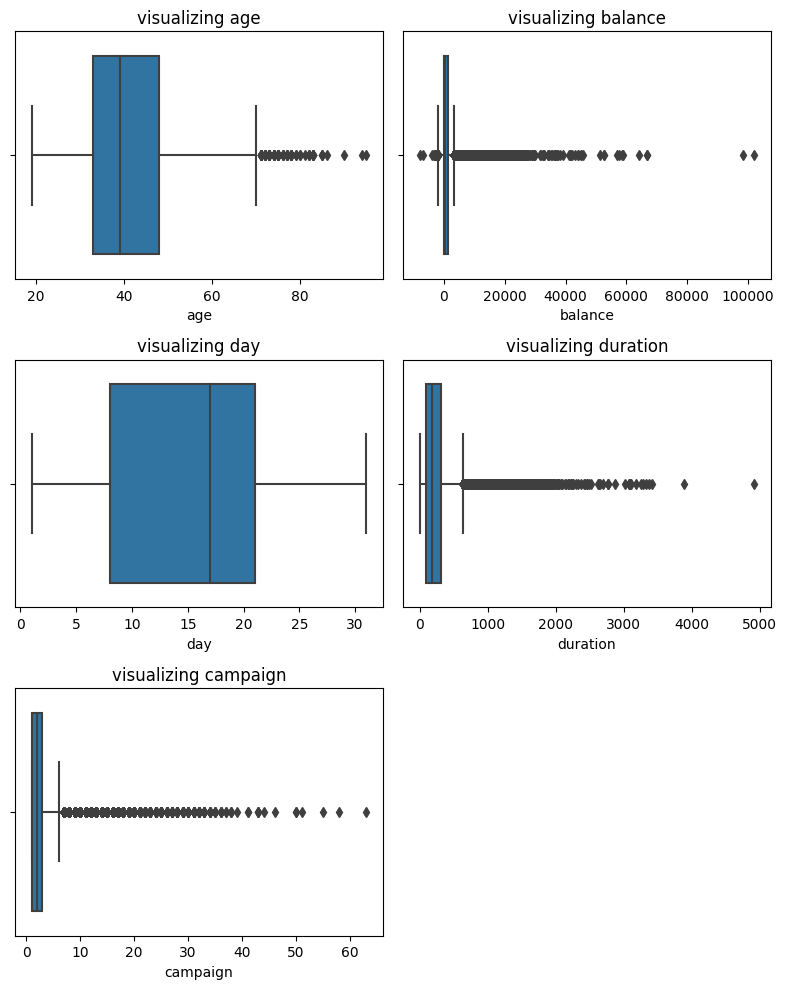

In [ ]:
num_visualization=numerical_and_categorical(data)
num_visualization.num_feats()

Age, Balance, Duration and Campaign have outlier values

Calculate percentage of Outliers

In [ ]:
def calc_outlier(df):
  for i in numerical_features:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - 1.5* iqr
    upper_limit = q3 + 1.5* iqr
  
    count = (df[i]<lower_limit) | (df[i]>upper_limit)
    count_percentage= (sum(count)/len(count)) *100
    print('Percentage of outliers in {} is {:.2f} %'.format(i,count_percentage))

In [ ]:
calc_outlier(data)

Percentage of outliers in age is 0.20 %
Percentage of outliers in balance is 10.70 %
Percentage of outliers in day is 0.00 %
Percentage of outliers in duration is 7.50 %
Percentage of outliers in campaign is 7.48 %


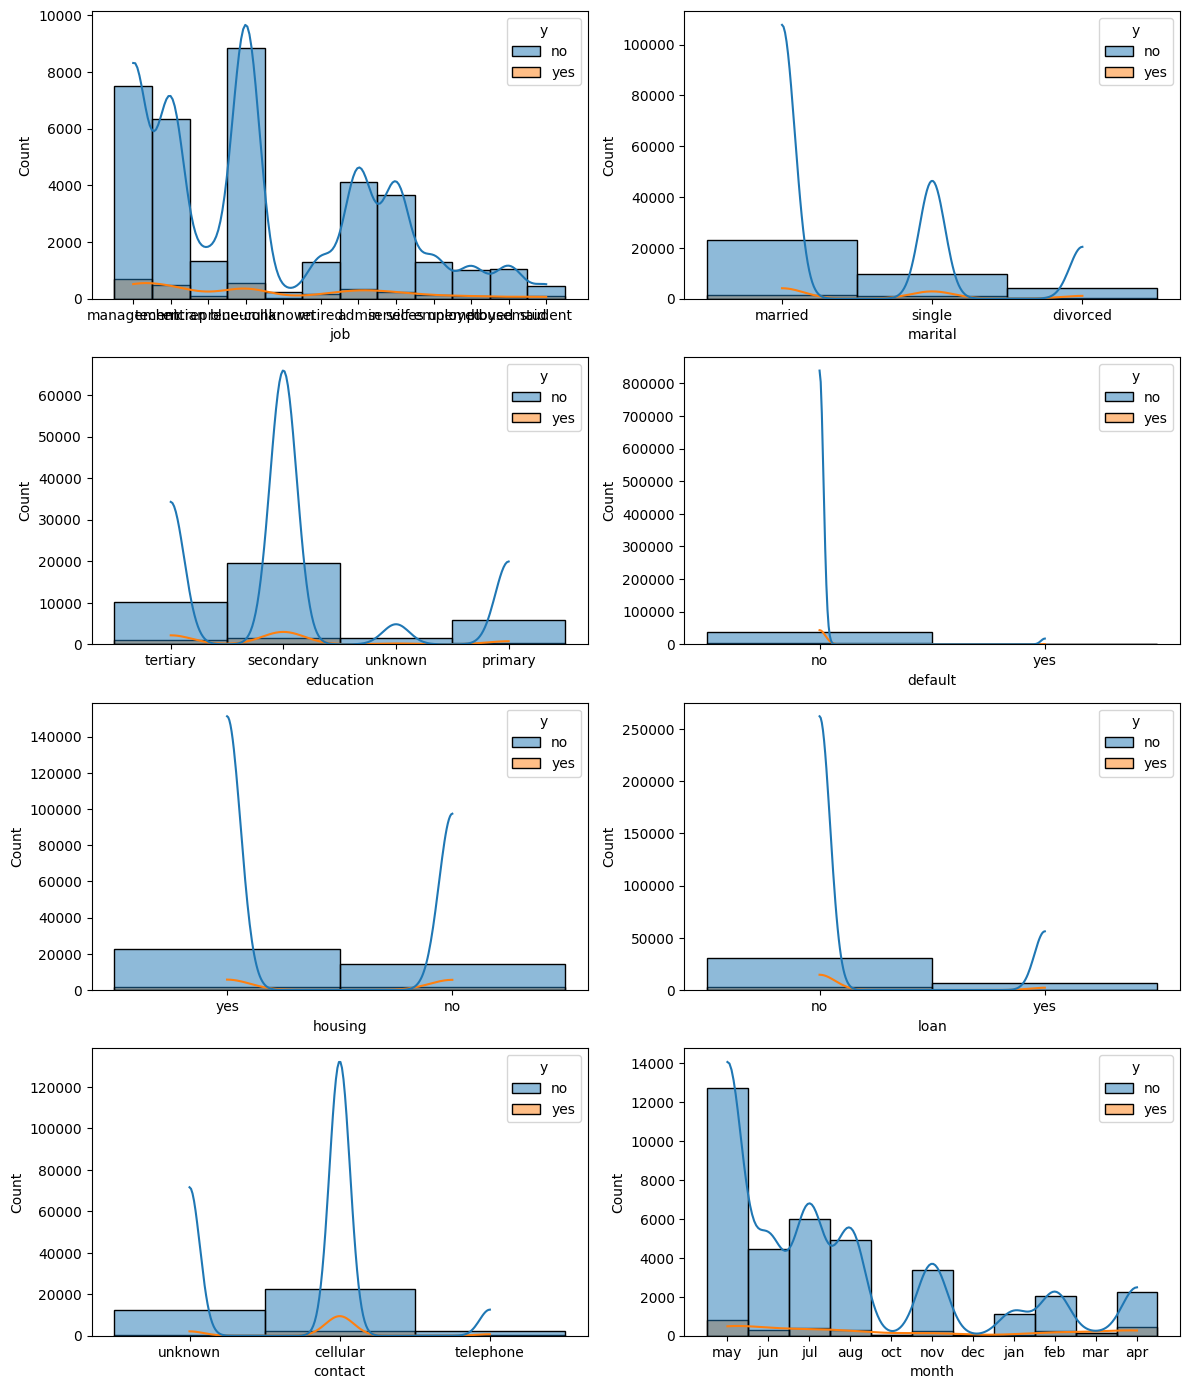

In [ ]:
categorical_visualize=numerical_and_categorical(data)
categorical_visualize.cat_feats()

job  admin  blue-collar  entrepreneur  housemaid  management  retired  \
y                                                                       
no    4132         8848          1317       1034        7490     1286   
yes    351          535            88         53         676      151   

job  self-employed  services  student  technician  unemployed  unknown  
y                                                                       
no            1302      3672      442        6355        1008      218  
yes            112       238       82         497          96       17  


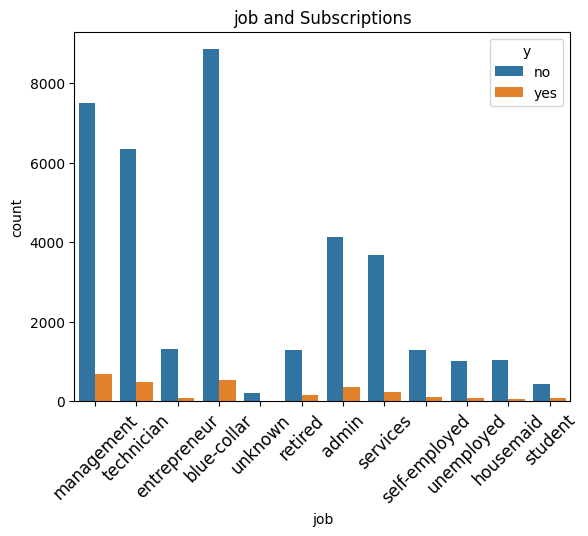

In [ ]:
visualize_job = freqs_and_countplot(data,'job')
visualize_job.count_freqs()
visualize_job.countplot()

marital  divorced  married  single
y                                 
no           4334    22908    9862
yes           391     1478    1027


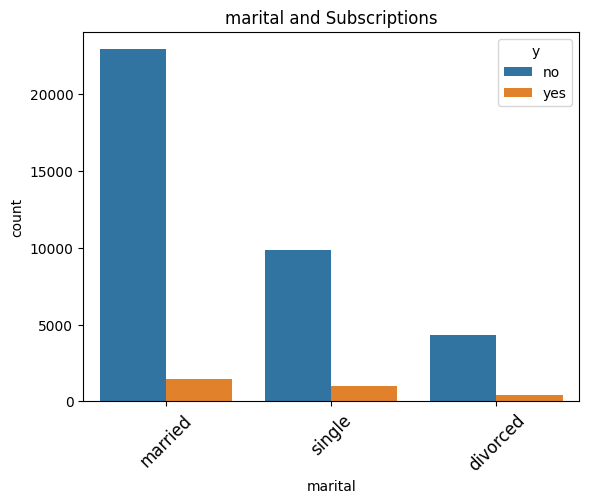

In [ ]:
visualize_marital = freqs_and_countplot(data,'marital')
visualize_marital.count_freqs()
visualize_marital.countplot()

education  primary  secondary  tertiary  unknown
y                                               
no            5917      19575     10177     1435
yes            353       1418      1029       96


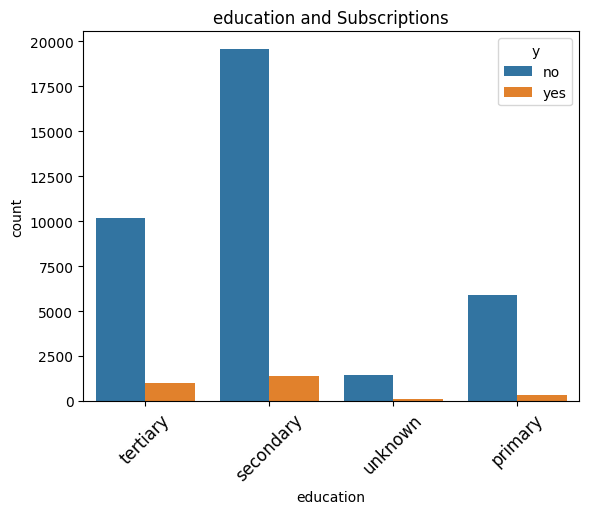

In [ ]:
visualize_education = freqs_and_countplot(data,'education')
visualize_education.count_freqs()
visualize_education.countplot()

default     no  yes
y                  
no       36344  760
yes       2847   49


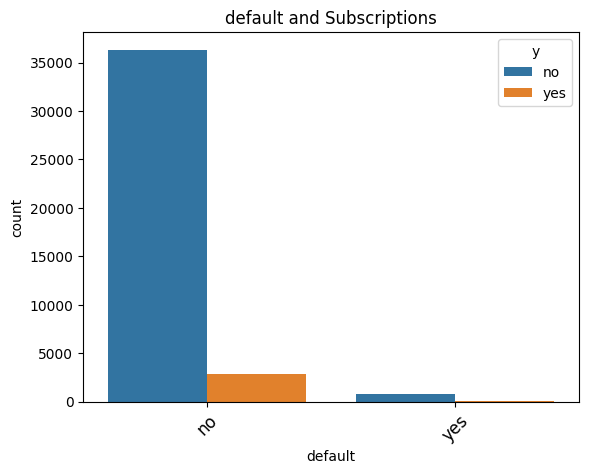

In [ ]:
visualize_default = freqs_and_countplot(data,'default')
visualize_default.count_freqs()
visualize_default.countplot()

housing     no    yes
y                    
no       14537  22567
yes       1432   1464


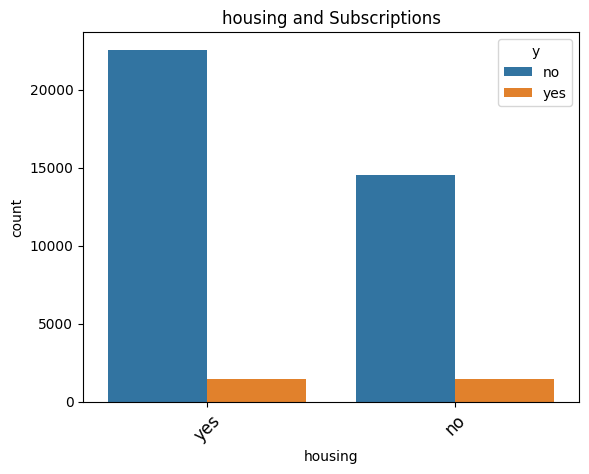

In [ ]:
visualize_housing = freqs_and_countplot(data,'housing')
visualize_housing.count_freqs()
visualize_housing.countplot()

loan     no   yes
y                
no    30554  6550
yes    2516   380


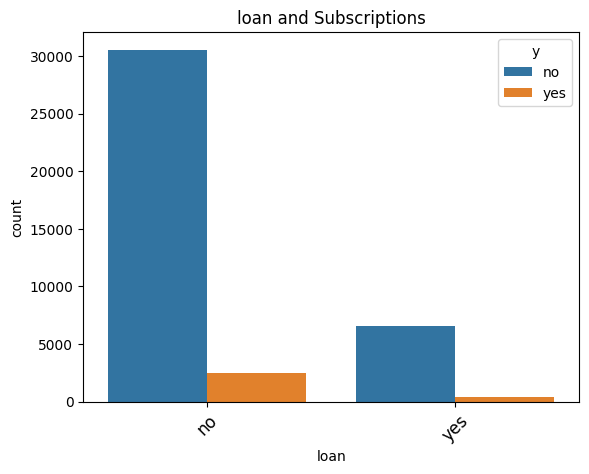

In [ ]:
visualize_loan = freqs_and_countplot(data,'loan')
visualize_loan.count_freqs()
visualize_loan.countplot()

contact  cellular  telephone  unknown
y                                    
no          22681       2155    12268
yes          2233        166      497


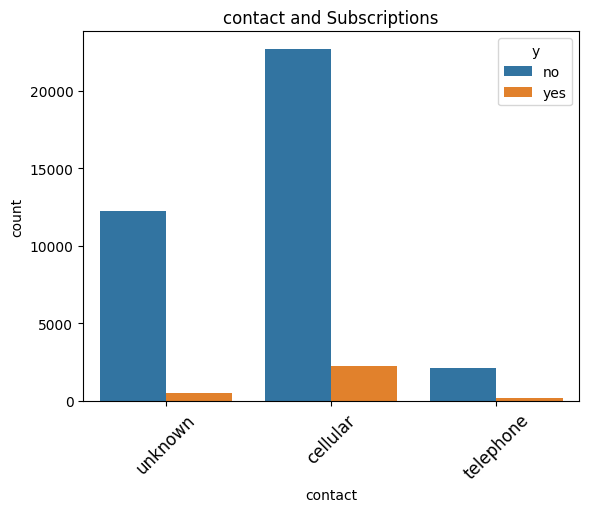

In [ ]:
visualize_contact = freqs_and_countplot(data,'contact')
visualize_contact.count_freqs()
visualize_contact.countplot()

month   apr   aug  dec   feb   jan   jul   jun  mar    may   nov  oct
y                                                                    
no     2267  4927   12  2041  1138  5996  4440  133  12741  3378   31
yes     451   288    1   255    38   384   294  125    791   220   49


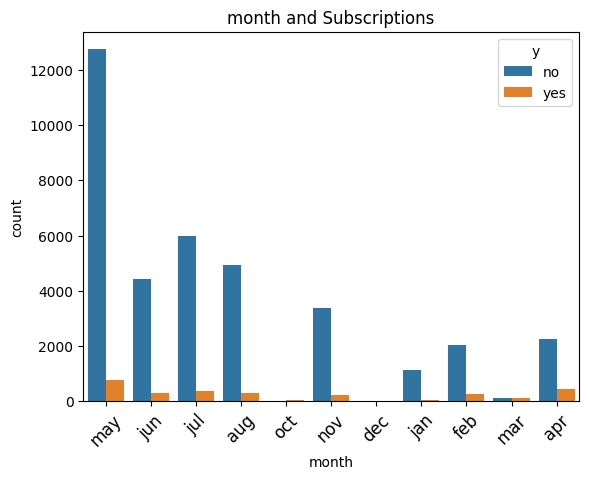

In [ ]:
visualize_month = freqs_and_countplot(data,'month')
visualize_month.count_freqs()
visualize_month.countplot()

* Most of the clients are either blue-collar or management, then comes technician.

* In marital status, single and divorced accepts the offer comparatively to Married ones. Eventhough count of Married people for accpeting offer is high, their rejection rate is also high.

* people who has credit in default and housing loan are more likely to decline the offer

* Contacting people in the month of April and in the interval june to august will be of positive result

### Preprocessing Dataset

In [ ]:
for col in data.iloc[:,:-1]:
  if col in categorical_features:
    contingency_table = pd.crosstab(data[col],data['y'])
    stat,p_val,ddof,expected = chi2_contingency(contingency_table)
    if p_val>0.05:
      print(f'{col} : fails to reject null hypothesis')
    else:
      print(f'{col} : rejects null hypothesis')

job : rejects null hypothesis
marital : rejects null hypothesis
education : rejects null hypothesis
default : fails to reject null hypothesis
housing : rejects null hypothesis
loan : rejects null hypothesis
contact : rejects null hypothesis
month : rejects null hypothesis


p value of "default" is greater than 0.05, implies that it is not statistically significant, so we can drop it.

In numerical columns "day" will not come up with practical importance, hence dropping it will be the best approach.

In [ ]:
final_df = preparing_dataset()
X,y = final_df.encode_features(data)

Preprocessing steps =>

* Removing outliers from the data (using IQR)
* split features and target into training and testing part (training size - 75%)
* Balance dataset by conducting both oversampling (using SMOTE) and under sampling(using NearMiss)
* scale features (using Standard scaler)

In [ ]:
X_train_nm, X_train_sm, X_test, y_train_nm, y_train_sm, y_test = final_df.preprocess_data(X, y)

Over sampling results: 
before smote : Counter({0: 21973, 1: 877})
after smote : Counter({0: 21973, 1: 21973})
Under sampling results: 
before NearMiss : Counter({0: 21973, 1: 877})
after NearMiss : Counter({0: 877, 1: 877})


In [ ]:
models=Model_creation()

### Logistic Regression

In [ ]:
param_values = {
    'classifier__C': [1.0, 1.5, 1.7, 2.0],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
}

In [ ]:
lr_nm1 = LogisticRegression(random_state=10)
lr_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, lr_nm1, param_values)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 accuracy score:  0.8628571428571429
f1 score:  0.8666666666666667
roc_auc:  0.8667763157894737
{'classifier__C': 1.0, 'classifier__penalty': None}


In [ ]:
lr_sm1 = LogisticRegression(random_state=10)
lr_sm = models.create_model(X_train_sm, y_train_sm,X_test,y_test, lr_sm1, param_values)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 accuracy score:  0.8197747183979975
f1 score:  0.8210978088999323
roc_auc:  0.8199024419698906
{'classifier__C': 1.0, 'classifier__penalty': None}


### Random Forest

In [ ]:
param_values = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15,None],
    'classifier__min_samples_split': [2, 5, 10]
}

In [ ]:
rf_nm1 = RandomForestClassifier(random_state=10)
rf_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, rf_nm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.9085714285714286
f1 score:  0.9135135135135135
roc_auc:  0.910361842105263
{'classifier__max_depth': 15, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [15]:
rf_sm1 = RandomForestClassifier(random_state=10)
rf_sm = models.create_model(X_train_sm, y_train_sm,X_test,y_test,rf_sm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.9523267721014905
f1 score:  0.9530005608524957
roc_auc:  0.9525254803847178
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


### Gradient boosting classifier

In [16]:
param_values = {
    'classifier__loss':['log_loss','deviance','exponential'],
    'classifier__learning_rate': [0.001,0.1,0.2],
    'classifier__n_estimators': [75,100,120,150]
}

In [17]:
gb_nm1 = GradientBoostingClassifier(random_state=10)
gb_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, gb_nm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.9142857142857143
f1 score:  0.9171270718232045
roc_auc:  0.918092105263158
{'classifier__learning_rate': 0.1, 'classifier__loss': 'exponential', 'classifier__n_estimators': 150}


In [18]:
gb_sm1 = GradientBoostingClassifier(random_state=10)
gb_sm = models.create_model(X_train_sm, y_train_sm,X_test,y_test,gb_sm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.899988622141313
f1 score:  0.9004868108230499
roc_auc:  0.9001015683567003
{'classifier__learning_rate': 0.2, 'classifier__loss': 'log_loss', 'classifier__n_estimators': 150}


### KNeighbors classifier

In [20]:
param_values = {
    'classifier__n_neighbors':[5,7,9],
    'classifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__weights':['uniform', 'distance']
}

In [22]:
kn_nm1 = KNeighborsClassifier()
kn_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, kn_nm1, param_values)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 accuracy score:  0.8057142857142857
f1 score:  0.8057142857142857
roc_auc:  0.8116776315789473
{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


In [23]:
kn_sm1 = KNeighborsClassifier()
kn_sm = models.create_model(X_train_sm, y_train_sm,X_test,y_test, kn_sm1, param_values)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 accuracy score:  0.9129593810444874
f1 score:  0.9175912959172681
roc_auc:  0.9135219212198684
{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}


### Linear SVC

In [32]:
param_values = {
    'classifier__C':[1.0,1.25,1.5]
}

In [33]:
svc_nm1 = LinearSVC()
svc_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, svc_nm1, param_values)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 accuracy score:  0.8657142857142858
f1 score:  0.8690807799442897
roc_auc:  0.8699013157894736
{'classifier__C': 1.0}


In [34]:
svc_sm1 = LinearSVC()
svc_sm = models.create_model(X_train_sm, y_train_sm, X_test,y_test, svc_sm1, param_values)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 accuracy score:  0.820912504266697
f1 score:  0.8228275551553355
roc_auc:  0.8210702217300457
{'classifier__C': 1.0}


### Extra trees classifier

In [37]:
param_values = {
    'classifier__n_estimators':[100,125,150,164],
    'classifier__criterion':['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [3, 5, None]
}

In [38]:
etc_nm1 = ExtraTreesClassifier()
etc_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, etc_nm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.8771428571428571
f1 score:  0.8840970350404314
roc_auc:  0.8784539473684212
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 100}


In [39]:
etc_sm1 = ExtraTreesClassifier()
etc_sm = models.create_model(X_train_sm, y_train_sm, X_test,y_test, etc_sm1, param_values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 accuracy score:  0.9528956650358402
f1 score:  0.9534308211473564
roc_auc:  0.9530694948583511
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 150}


###Decision Tree Classifier

In [40]:
param_values = {
    'classifier__criterion':['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_split':[2,4,6,10],
    'classifier__max_depth':[5,10,12,15,20,None]
}

In [41]:
dtc_nm1 = DecisionTreeClassifier()
dtc_nm = models.create_model(X_train_nm, y_train_nm,X_test,y_test, dtc_nm1, param_values)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
 accuracy score:  0.8942857142857142
f1 score:  0.899182561307902
roc_auc:  0.8967105263157895
{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 10}


In [42]:
dtc_sm1 = DecisionTreeClassifier()
dtc_sm = models.create_model(X_train_sm, y_train_sm, X_test,y_test, dtc_sm1, param_values)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
 accuracy score:  0.9315052907042894
f1 score:  0.9325565762939727
roc_auc:  0.9317133664640995
{'classifier__criterion': 'log_loss', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}


Random Forest Classifier and Extra tree classifier are having accuracy of 95% by conducting Over sampling